In [9]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut

from sampler import sample_from_logreg

import numpy as np
import matplotlib.pyplot as plt

from cv_svm import SVM_smooth

#import matplotlib
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})

In [2]:
X, y = load_breast_cancer(return_X_y=True)
#X, y = make_classification(n_samples=250, n_features=50)
#X, _, y = sample_from_logreg(n=250, p=20, seed=120)
n = X.shape[0]
p = X.shape[1]
y[np.where(y == 0)] = -1

In [3]:
X = StandardScaler().fit_transform(X)
#X_scaled = X
print(X.shape)

(569, 30)


In [4]:
sigma = 1e-1
lbd = 1

In [5]:
# calculate maximum bound
from sklearn.metrics import pairwise_distances
m_max = np.min(pairwise_distances(X))
print(m_max)

C = np.linalg.norm(X.T @ X)/n

max_bound = 1 + C/(lbd * sigma) *\
            1/(2 * np.sqrt(1 + (m_max/sigma)**2)**3)
print(max_bound)

# what lambda do we have to pick?
b = 200
lbd_pick = C/((b - 1) * sigma) *\
            1/(2 * np.sqrt(1 + (m_max/sigma)**2)**3)
lbd_pick

0.0
76.17939684051998


0.37778591377145715

In [6]:
# can we control the condition number for different sigma?
sigmas = [2e-3, 2e-2, 5e-2, 2e-1, 4e-1, 8e-1, 1, 1.25, 20]
mean_cond_nums = []
lbd_picks = []

bounds = [4, 10, 100, 400]
for b in bounds:
    inter = []
    inter_lbd = []
    for s in sigmas:
        #m_max = s
        lbd_pick = C/((b - 1) * s) *\
                    1/(2 * np.sqrt(1 + (m_max/s)**2)**3)
        
        if lbd_pick > 1e3:
            continue

        print(f"running experiment for sigma = {s} | lbd = {lbd_pick}")
        clf = SVM_smooth(sigma=s, lbd=lbd_pick)
        clf.fit(X, y, thresh=1e-4, n_iter=1500, eta=0.5/n,
                approx_cv=True, log_iter=False, log_iacv=False,
                save_cond_nums=True, cv=False,
                warm_start=0, normalise=False, adjust_factor=True,
                save_hessian_norms=False)
        inter.append(np.mean(clf.cond_nums_))
        inter_lbd.append(lbd_pick)
        print(f"\t cond num {np.mean(clf.cond_nums_)}")
        print(f"\t grad {np.linalg.norm(clf.nabla_fgd_(clf.weights_, X, y, clf.sigma_, clf.lbd_))}")
    mean_cond_nums.append(inter)
    lbd_picks.append(inter_lbd)

running experiment for sigma = 0.02 | lbd = 125.29899473419998
stopping early at iteration 88
	 cond num 1.0000333786010742
	 grad 9.831294229105722e-05
running experiment for sigma = 0.05 | lbd = 50.11959789367998
stopping early at iteration 226
	 cond num 1.016272783279419
	 grad 9.611735640693198e-05
running experiment for sigma = 0.2 | lbd = 12.529899473419995
stopping early at iteration 716
	 cond num 1.5588079690933228
	 grad 9.955789601502103e-05
running experiment for sigma = 0.4 | lbd = 6.2649497367099976
stopping early at iteration 1306
	 cond num 2.1120858192443848
	 grad 9.94506161961733e-05
running experiment for sigma = 0.8 | lbd = 3.1324748683549988
	 cond num 2.3516881465911865
	 grad 0.0019318438066021296
running experiment for sigma = 1 | lbd = 2.5059798946839993
	 cond num 2.395793914794922
	 grad 0.0046893482924602135
running experiment for sigma = 1.25 | lbd = 2.0047839157471996
	 cond num 2.4369888305664062
	 grad 0.010369082417052458
running experiment for sigma 

In [10]:
for i, b in enumerate(bounds):
    fig, ax = plt.subplots()
    fr =  len(sigmas) - len(mean_cond_nums[i])
    ax.plot(sigmas[fr:], mean_cond_nums[i], c='blue')

    ax.set_title(f'$b$ = {b}')
    ax.set_xscale('log')
    ax.set_xlabel("$\log(\sigma)$")
    ax.set_ylabel("Condition No.")
    
    ax2 = ax.twinx()
    ax2.plot(sigmas[fr:], lbd_picks[i], c='purple', alpha=0.4, linestyle='--')
    ax2.set_yscale('log')
    ax2.set_ylabel("$\log(\lambda_b)$")
    ws = 1.45 # 1.75
    hs = 1.35 # 1.25
    fig.set_size_inches(w=5.73/ws, h=3.5/hs)
    plt.show()
    plt.savefig(f'svm_bound_cond_no_heart_lbd_{b}.pgf', bbox_inches='tight', pad_inches=0)

/tmp/ipykernel_10452/2716455078.py:18: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()
/tmp/ipykernel_10452/2716455078.py:18: UserWarning: FigureCanvasPgf is non-interactive, and thus cannot be shown
  plt.show()


ValueError: x and y must have same first dimension, but have shapes (9,) and (8,)

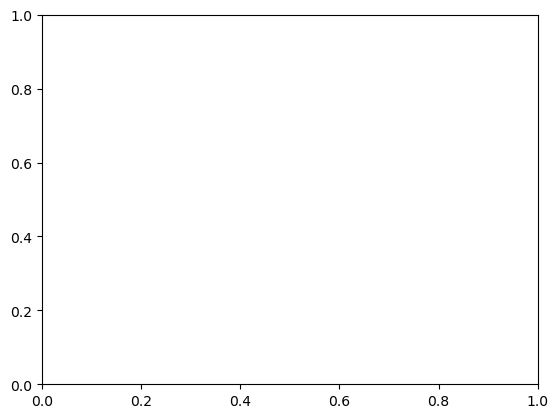

In [8]:
for i, b in enumerate(bounds):
    fig, ax = plt.subplots()
    ax.plot(sigmas, lbd_picks[i], c='purple')

    ax.set_title(f'$b$ = {b}')
    ax.set_xscale('log')
    ax.set_xlabel("$\log(\sigma)$")
    ax.set_ylabel("$\lambda$")
    ws = 1.45 # 1.75
    hs = 1.35 # 1.25
    fig.set_size_inches(w=5.73/ws, h=3.5/hs)
    plt.show()
    #plt.savefig(f'svm_bound_cond_no_{b}.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(sigmas, mean_cond_nums, c='purple')
ax.plot(sigmas, np.ones(len(sigmas)) * b, linestyle='--', c='black')

#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("$\sigma$")
ax.set_ylabel("Condition No.")
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.min(clf.cond_nums_, axis=1), label="Min Condition Number", c='b')
ax.plot(np.max(clf.cond_nums_, axis=1), label="Max Condition Number", c='r')
ax.plot(np.mean(clf.cond_nums_, axis=1), label="Mean Condition Number", c='purple')
#ax.plot(clf.cond_num_bound_, label="Bound", c="black", linestyle="--")

#ax.set_yscale('log')
ax.set_xlabel("Iterations")
ax.set_ylabel("Condition No.")
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
fig.legend()
plt.show()
#plt.savefig('svm_convergence_cond_no.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
np.mean(clf.cond_nums_, axis=1)[np.argmax(np.mean(clf.cond_nums_, axis=1))]

In [ ]:
fig, ax = plt.subplots()
ax.plot(clf.err_approx_["IACV"], label="IACV", c='black')
#ax.plot(clf.err_approx_["NS"], label="NS", c='red', linestyle="--")
ax.plot(clf.err_approx_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err Approx (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('svm_convergence_err_approx_mod.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(clf.err_cv_["IACV"], label="IACV", c='black')
ax.plot(clf.err_cv_["baseline"], label="Baseline", c='green', linestyle="--")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Iterations (log)")
ax.set_ylabel("Err CV (log)")
ax.legend()
ws = 1.45 # 1.75
hs = 1.35 # 1.25
fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.show()
#plt.savefig('svm_convergence_err_cv_mod.pgf', bbox_inches='tight', pad_inches=0)